# Obtaining data for MA-DPG evaluation form example 02b


In [7]:
# Module imports
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

# assume module imports
import examples.examples as examples
from assume import World
from assume.scenario.loader_csv import load_file, load_scenario_folder, run_learning

## 1. Running example 02b

In [8]:
example = "small_learning_2"
db_uri = "sqlite:///../local_db/assume_db.db"
inputs_dir = "../inputs"

scenario = examples.available_examples[example]["scenario"]
study_case = examples.available_examples[example]["study_case"]
csv_path = "outputs/" + scenario + "/" + study_case

In [9]:
# Run example 02b
world = World(database_uri=db_uri, export_csv_path=csv_path)
load_scenario_folder(world, inputs_dir, scenario, study_case)
run_learning(
    world,
    inputs_dir,
    scenario,
    study_case,
)
world.run()

INFO:assume.world:connected to db


C:\Users\tg3533\Documents\Code\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



C:\Users\tg3533\Documents\Code\assume\assume\common\forecasts.py:323: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

example_02b_base_1 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:04<00:00, 629949.06it/s]
example_02b_base_2 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:05<00:00, 516878.53it/s]
example_02b_base_3 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:06<00:00, 436339.31it/s]
example_02b_base_4 2019-03-31 23:00:00: 100%|█████████▉| 2674801.0/2678400 [00:56<00:00, 47347.43it/s]
C:\Users\tg3533\Documents\Code\assume\assume\reinforcement_learning\tensorboard_logger.py:170: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

example_02b_base_5 

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=292.57


example_02b_base 2019-03-31 23:00:00: 100%|█████████▉| 2674801/2678400 [00:05<00:00, 501147.97it/s]


## 2. Retrieving the data from the best run

In [10]:
# Best actors directory
best_actors_dir = os.path.join(
    inputs_dir,
    scenario,
    "learned_strategies",
    study_case,
    "avg_reward_eval_policies/actors/",
)
actors = os.listdir(best_actors_dir)
actors

['actor_pp_10.pt',
 'actor_pp_6.pt',
 'actor_pp_7.pt',
 'actor_pp_8.pt',
 'actor_pp_9.pt']

### 2.1 Retrieving bets run actions:

In [11]:
# Get the config file
config_path = os.path.join(inputs_dir, scenario, "config.yaml")

# Read the number of validation episodes from the config file
with open(config_path) as file:
    config = yaml.safe_load(file)[study_case]
learning_config = config["learning_config"]
no_of_val_episodes = (
    learning_config["training_episodes"]
    - learning_config["episodes_collecting_initial_experience"]
) // learning_config.get("validation_episodes_interval", 5)

In [12]:
# Set up the database connection
db = create_engine(db_uri)
simulation = f"{scenario}_{study_case}_eval"

# Get the average reward for each episode in order to determine the best episode.
reward_df = pd.DataFrame(columns=["avg_reward"], index=range(1, no_of_val_episodes + 1))
for episode in range(1, no_of_val_episodes + 1):
    query = f"SELECT AVG(reward) as avg_reward FROM rl_params where simulation = '{simulation}_{episode}'"
    reward_df.at[episode, "avg_reward"] = pd.read_sql(query, db).values[0][0]
reward_df.head()

,avg_reward
1,0.393765


In [13]:
episode = reward_df["avg_reward"].idxmax()
query = f"SELECT datetime as dt, unit, actions_0, actions_1 FROM rl_params where simulation = '{simulation}_{episode}'"
actions_df = pd.read_sql(query, db)
actions_df.index = pd.to_datetime(actions_df["dt"])
actions_df.drop(columns=["dt"], inplace=True)
actions_df

,unit,actions_0,actions_1
dt,,,
2019-03-01 01:00:00,pp_6,0.718906,0.980920
2019-03-01 01:00:00,pp_7,0.132761,0.974664
2019-03-01 01:00:00,pp_8,-0.203699,0.851351
2019-03-01 01:00:00,pp_9,0.845937,0.884499
2019-03-01 01:00:00,pp_10,0.970175,0.897738
...,...,...,...
2019-03-31 23:00:00,pp_6,0.600777,0.983233
2019-03-31 23:00:00,pp_7,-0.494684,0.979775
2019-03-31 23:00:00,pp_8,0.166812,0.682004


## 2.2 Getting the demand dataframe and power plant units

In [14]:
start = pd.Timestamp(config["start_date"])
end = pd.Timestamp(config["end_date"])

index = pd.date_range(
    start=start,
    end=end,
    freq=config["time_step"],
)

demand_df = load_file(
    os.path.join(inputs_dir, scenario), config, file_name="demand_df", index=index
)
demand_df

,demand_EOM
2019-03-01 00:00:00,5078.7
2019-03-01 01:00:00,4920.7
2019-03-01 02:00:00,4832.5
2019-03-01 03:00:00,4849.5
2019-03-01 04:00:00,5014.2
...,...
2019-03-31 20:00:00,5146.6
2019-03-31 21:00:00,5073.1
2019-03-31 22:00:00,4761.7
2019-03-31 23:00:00,4437.5


In [15]:
pp_units = pd.read_csv(
    os.path.join(inputs_dir, scenario, "powerplant_units.csv"), index_col=0
)
pp_units

,technology,bidding_EOM,fuel_type,emission_factor,max_power,min_power,efficiency,additional_cost,unit_operator
name,,,,,,,,,
pp_1,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1
pp_2,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1
pp_3,lignite,naive_eom,lignite,0.406,1000,1,0.41,2.0,Operator 1
pp_4,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1
pp_5,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1
pp_6,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_7,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_8,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1
pp_9,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1


In [16]:
# TODO: ich brauche die Daten für den dispatch vom best run
# heißt hier muss die normale simulation (kein eval run) noch mal laufen gelassen werden mit den best_actors von vorher, sonst speichert er die dispatch Daten nicht
# sofern ich das richtig sehe

episode = reward_df["avg_reward"].idxmax()
query = f"SELECT * FROM unit_dispatch where simulation = 'example_02b_base'"
dispatch_df = pd.read_sql(query, db)

#drop duplicates time and unit and keep second
#TODO: fix double logging of dispatch_df (future I guess, ich hab nen quick fix gemacht)
dispatch_df = dispatch_df.drop_duplicates(subset=["time", "unit"], keep="first")
dispatch_df

,time,power,energy_cashflow,energy_marginal_costs,unit,total_costs,simulation,heat
0,2019-03-01 00:00:00.000000,0.0,0.000000,0.000000e+00,pp_1,NaN,example_02b_base,0.0
1,2019-03-01 01:00:00.000000,1000.0,36156.250000,1.250000e+04,pp_1,NaN,example_02b_base,0.0
2,2019-03-01 00:00:00.000000,0.0,0.000000,0.000000e+00,pp_2,NaN,example_02b_base,0.0
3,2019-03-01 01:00:00.000000,1000.0,36156.250000,1.250000e+04,pp_2,NaN,example_02b_base,0.0
4,2019-03-01 00:00:00.000000,0.0,0.000000,0.000000e+00,pp_3,NaN,example_02b_base,0.0
...,...,...,...,...,...,...,...,...
17823,2019-03-31 23:00:00.000000,1.0,36.156250,5.570833e+01,pp_8,55.708333,example_02b_base,0.0
17825,2019-03-31 23:00:00.000000,1.0,36.156250,5.570833e+01,pp_9,55.708333,example_02b_base,0.0
17827,2019-03-31 23:00:00.000000,1.0,36.156250,5.570833e+01,pp_10,55.708333,example_02b_base,0.0
17829,2019-03-31 23:00:00.000000,0.0,0.000000,0.000000e+00,pp_11,NaN,example_02b_base,0.0


In [17]:
# TODO: check are these only the accepted offers? 
# We need all, because potentialy a different behavior of the agent we optimise and validate could change the market so that a former rejected offer is now accepted

episode = reward_df["avg_reward"].idxmax()
query = f"SELECT * FROM market_orders where simulation = 'example_02b_base'"
market_orders_df = pd.read_sql(query, db)
market_orders_df

,start_time,end_time,price,volume,node,bid_id,unit_id,accepted_volume,accepted_price,market_id,bid_type,simulation
0,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,-20.369871,1.0,node0,pp_8_1,pp_8,1.0,36.15625,EOM,None,example_02b_base
1,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,12.500000,1000.0,node0,pp_2_1,pp_2,1000.0,36.15625,EOM,None,example_02b_base
2,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,12.500000,1000.0,node0,pp_1_1,pp_1,1000.0,36.15625,EOM,None,example_02b_base
3,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,13.276085,1.0,node0,pp_7_1,pp_7,1.0,36.15625,EOM,None,example_02b_base
4,2019-03-01 01:00:00.000000,2019-03-01 02:00:00.000000,31.146341,1000.0,node0,pp_3_1,pp_3,1000.0,36.15625,EOM,None,example_02b_base
...,...,...,...,...,...,...,...,...,...,...,...,...
12626,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,85.708333,5000.0,node0,pp_11_1,pp_11,0.0,36.15625,EOM,None,example_02b_base
12627,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,91.141792,499.0,node0,pp_9_2,pp_9,0.0,36.15625,EOM,None,example_02b_base
12628,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,92.915115,499.0,node0,pp_10_2,pp_10,0.0,36.15625,EOM,None,example_02b_base
12629,2019-03-31 23:00:00.000000,2019-04-01 00:00:00.000000,97.977509,499.0,node0,pp_7_2,pp_7,0.0,36.15625,EOM,None,example_02b_base


# 3. Establish Sampling of days to be analysed

Here we sample from the entire training data a subset of days, for which we test if the profit of all drl agents is similar to their MPEC formulation. 

## 3.1 Get sample subset

In [18]:
sample_size = 0.1 # percentage of overall data

# sample 10% of the datetime indices
dates = np.unique(demand_df.index.date)
sampled_dates = pd.Index(dates).to_series().sample(frac=sample_size, random_state=42)

demand_df['date']=demand_df.index.date
sample_demand_df = demand_df.loc[demand_df['date'].isin(sampled_dates)]
rest_demand_df = demand_df.loc[~demand_df['date'].isin(sampled_dates)]
sample_demand_df

,demand_EOM,date
2019-03-16 00:00:00,5180.4,2019-03-16
2019-03-16 01:00:00,4940.1,2019-03-16
2019-03-16 02:00:00,4790.7,2019-03-16
2019-03-16 03:00:00,4749.2,2019-03-16
2019-03-16 04:00:00,4771.9,2019-03-16
...,...,...
2019-03-30 19:00:00,5533.8,2019-03-30
2019-03-30 20:00:00,5264.4,2019-03-30
2019-03-30 21:00:00,4947.3,2019-03-30
2019-03-30 22:00:00,4786.8,2019-03-30


In [19]:
actions_df['date']=actions_df.index.date

sample_actions_df = actions_df.loc[actions_df['date'].isin(sampled_dates)]
rest_actions_df = actions_df.loc[~actions_df['date'].isin(sampled_dates)]
sample_actions_df

,unit,actions_0,actions_1,date
dt,,,,
2019-03-16 00:00:00,pp_6,0.939386,0.991353,2019-03-16
2019-03-16 00:00:00,pp_7,0.776608,0.965457,2019-03-16
2019-03-16 00:00:00,pp_8,0.917667,0.646474,2019-03-16
2019-03-16 00:00:00,pp_9,0.974236,-0.715124,2019-03-16
2019-03-16 00:00:00,pp_10,0.913806,0.953041,2019-03-16
...,...,...,...,...
2019-03-30 23:00:00,pp_6,0.675284,0.994706,2019-03-30
2019-03-30 23:00:00,pp_7,-0.873510,0.980425,2019-03-30
2019-03-30 23:00:00,pp_8,0.982420,0.946480,2019-03-30


In [20]:
dispatch_df.index = pd.to_datetime(dispatch_df['time'])
dispatch_df = dispatch_df.drop(columns=['time'])
dispatch_df['date']=dispatch_df.index.date

sample_dispatch_df = dispatch_df.loc[dispatch_df['date'].isin(sampled_dates)]
rest_dispatch_df = dispatch_df.loc[~dispatch_df['date'].isin(sampled_dates)]
sample_dispatch_df

,power,energy_cashflow,energy_marginal_costs,unit,total_costs,simulation,heat,date
time,,,,,,,,
2019-03-16 00:00:00,1000.0,85708.333333,1.250000e+04,pp_1,NaN,example_02b_base,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,85708.333333,1.250000e+04,pp_2,NaN,example_02b_base,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,85708.333333,3.114634e+04,pp_3,NaN,example_02b_base,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,85708.333333,3.615625e+04,pp_4,NaN,example_02b_base,0.0,2019-03-16
2019-03-16 00:00:00,1000.0,85708.333333,3.615625e+04,pp_5,NaN,example_02b_base,0.0,2019-03-16
...,...,...,...,...,...,...,...,...
2019-03-30 23:00:00,0.0,0.000000,0.000000e+00,pp_8,0.000000,example_02b_base,0.0,2019-03-30
2019-03-30 23:00:00,1.0,36.156250,5.570833e+01,pp_9,55.708333,example_02b_base,0.0,2019-03-30
2019-03-30 23:00:00,1.0,36.156250,5.570833e+01,pp_10,55.708333,example_02b_base,0.0,2019-03-30


In [21]:
# sample market orders as well
market_orders_df.index = pd.to_datetime(market_orders_df['start_time'])
market_orders_df = market_orders_df.drop(columns=['start_time'])
market_orders_df['date']=market_orders_df.index.date

sample_market_orders_df = market_orders_df.loc[market_orders_df['date'].isin(sampled_dates)]
rest_market_orders_df = market_orders_df.loc[~market_orders_df['date'].isin(sampled_dates)]
sample_market_orders_df

,end_time,price,volume,node,bid_id,unit_id,accepted_volume,accepted_price,market_id,bid_type,simulation,date
start_time,,,,,,,,,,,,
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,-71.512421,1.0,node0,pp_9_1,pp_9,1.0,85.708333,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_2_1,pp_2,1000.0,85.708333,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,12.500000,1000.0,node0,pp_1_1,pp_1,1000.0,85.708333,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,31.146341,1000.0,node0,pp_3_1,pp_3,1000.0,85.708333,EOM,None,example_02b_base,2019-03-16
2019-03-16 00:00:00,2019-03-16 01:00:00.000000,36.156250,1000.0,node0,pp_4_1,pp_4,1000.0,85.708333,EOM,None,example_02b_base,2019-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,95.118408,499.0,node0,pp_10_2,pp_10,0.0,36.156250,EOM,None,example_02b_base,2019-03-30
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,97.506088,499.0,node0,pp_9_2,pp_9,0.0,36.156250,EOM,None,example_02b_base,2019-03-30
2019-03-30 23:00:00,2019-03-31 00:00:00.000000,98.042511,499.0,node0,pp_7_2,pp_7,0.0,36.156250,EOM,None,example_02b_base,2019-03-30


## 3.2 Analyse sample distribution in comparison to entire dataset

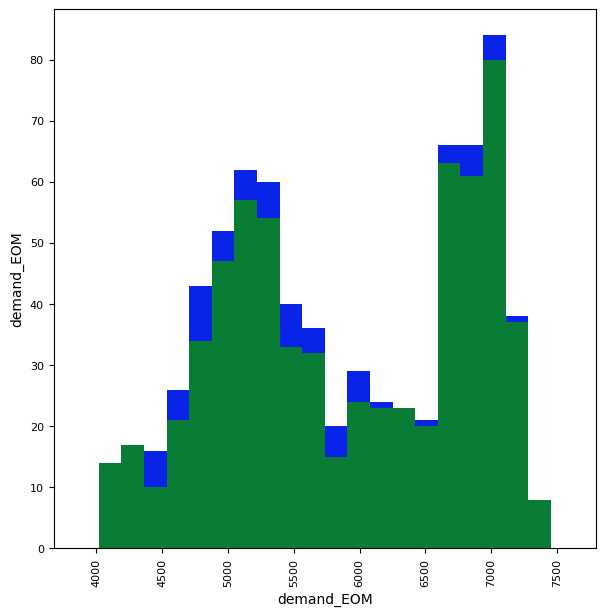

In [22]:
colors = list(["green"] * len(rest_demand_df)) + list(["blue"] * len(sample_demand_df))

# Scatter matrix
fig = pd.plotting.scatter_matrix(
    pd.concat([rest_demand_df, sample_demand_df], sort=False),
    c=colors,
    figsize=(7, 7),
    range_padding=0.2,
    hist_kwds={"bins": 20},  # Generic histogram configuration
    s=30,
    alpha=0.5,
)

# Customize histogram colors for each diagonal
hist_colors = ["green", "blue"]
for i, ax in enumerate(fig.diagonal()):
    data_combined = pd.concat([rest_demand_df.iloc[:, i], sample_demand_df.iloc[:, i]])
    ax.hist(
        [rest_demand_df.iloc[:, i], sample_demand_df.iloc[:, i]],
        bins=20,
        color=hist_colors,
        stacked=True,
        alpha=0.7,
    )

# Show plot
plt.show()

In [23]:
scaler = StandardScaler()
scaled_rest = scaler.fit_transform(rest_demand_df)
scaled_sample = scaler.transform(sample_demand_df)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(np.append(scaled_rest, scaled_sample, axis=0))

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, alpha=0.7)
plt.title("t-SNE Dimensionality Reduction")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.show()

TypeError: float() argument must be a string or a real number, not 'datetime.date'

## 2.3 Bi-Level Optimisation 

In [24]:
from MPEC.bilevel_opt import find_optimal_dispatch
from MPEC.uc_problem import solve_uc_problem
from MPEC.utils import calculate_profits

### Defintion for case

In [25]:
case = "test_case"

big_w = 100000  # weight for duality gap objective
k_max = 2  # maximum multiplier for strategic bidding
opt_gen = 1  # generator index that is allowed to bid strategically

start = pd.to_datetime("2019-03-02 06:00")
end = pd.to_datetime("2019-03-02 14:00")

# gens
gens_df = pp_units.copy()

# 24 hours of demand first increasing and then decreasing
demand_df = sample_demand_df.copy()
demand_df.index = pd.to_datetime(demand_df.index)
demand_df = demand_df.loc[start:end]
# reset index to start at 0
demand_df = demand_df.reset_index(drop=True)

## Input data transformation for Optimisation Problem 

In [26]:
# Transform gen_df into the format that is expected by the optimization problem
# g_max	mc	u_0	g_0	r_up	r_down	k_up	k_down
gens_df=gens_df.reset_index()
gens_df=gens_df.rename(columns={'max_power':'g_max', 'min_power':'u_0'})
gens_df['r_up']=gens_df['g_max'] # ramping up constraints
gens_df['r_down']=gens_df['g_max'] # ramping down constraints
gens_df['k_up']=0 # start up costs
gens_df['k_down']=0 # shut down costs
gens_df['g_0']=0 #start with no power output

# get average mc from dispatch_df per unit name
mc = dispatch_df.groupby('unit')['energy_marginal_costs'].mean()

# based on name and unit column join mc into gens_df
gens_df = gens_df.merge(mc, left_on='name', right_on='unit', how='left')
gens_df=gens_df.rename(columns={'energy_marginal_costs':'mc'})
gens_df

,name,technology,bidding_EOM,fuel_type,emission_factor,g_max,u_0,efficiency,additional_cost,unit_operator,r_up,r_down,k_up,k_down,g_0,mc
0,pp_1,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1,1000,1000,0,0,0,12483.198925
1,pp_2,nuclear,naive_eom,uranium,0.000,1000,1,0.36,10.0,Operator 1,1000,1000,0,0,0,12483.198925
2,pp_3,lignite,naive_eom,lignite,0.406,1000,1,0.41,2.0,Operator 1,1000,1000,0,0,0,31104.478101
3,pp_4,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1,1000,1000,0,0,0,34509.595237
4,pp_5,hard coal,naive_eom,hard coal,0.335,1000,1,0.48,1.0,Operator 1,1000,1000,0,0,0,34222.643880
5,pp_6,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,2284.356149
6,pp_7,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,7294.654329
7,pp_8,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,4557.465804
8,pp_9,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,12333.308350
9,pp_10,combined cycle gas turbine,pp_learning,natural gas,0.201,500,1,0.60,4.0,Operator 1,500,500,0,0,0,9322.048303


### Translate actions of RL model into k_values

In [27]:
# Merge on both 'unit_id' and 'time' columns
merged_df=sample_market_orders_df.merge(
    sample_dispatch_df.reset_index(),
    left_on=['unit_id', 'start_time'],
    right_on=['unit', 'time'],
    how='right'
)

In [28]:
# TODO: how to translate the 2 actions per unit into one k_value? Currently:
# get max price per unit_id and date  in the dataframe
id_k=merged_df.groupby(['unit_id', 'time'])['price'].idxmax()
k_df = merged_df.loc[id_k]

# transformed actions into k_values, one per generator
#TODO: divide this by the average marginal costs calculated in gens_df
k_df['k']=k_df['price']/k_df['energy_marginal_costs']

#replace inf with 0	
k_df['k']=k_df['k'].replace(np.inf, 0)

k_values_df = k_df.pivot(index='time', columns='unit_id', values='k')
#k_values_df.reset_index(inplace=True)
k_values_df

unit_id,demand_EOM,pp_1,pp_10,pp_11,pp_2,pp_3,pp_4,pp_5,pp_6,pp_7,pp_8,pp_9
time,,,,,,,,,,,,
2019-03-16 00:00:00,0.000193,0.001,0.000000,0.005637,0.001,0.001,0.001000,0.001000,0.0,1.733057,1.647270,1.748815
2019-03-16 01:00:00,0.000202,0.001,0.000000,0.000000,0.001,0.001,0.001066,0.001000,0.0,1.573725,0.000000,1.694393
2019-03-16 02:00:00,0.000209,0.001,0.000000,0.000000,0.001,0.001,0.003452,0.001000,0.0,1.588904,0.000000,-0.001072
2019-03-16 03:00:00,0.000211,0.001,0.000000,0.000000,0.001,0.001,0.001340,0.001000,0.0,1.173831,1.639536,1.109943
2019-03-16 04:00:00,0.000210,0.001,1.028019,0.000000,0.001,0.001,0.001000,0.001301,0.0,1.222079,1.692061,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-30 19:00:00,0.000181,0.001,0.045120,0.000000,0.001,0.001,0.001000,0.001000,0.0,0.002614,1.778595,1.753540
2019-03-30 20:00:00,0.000190,0.001,1.666116,0.003826,0.001,0.001,0.001000,0.001000,0.0,1.752113,1.777484,0.000000
2019-03-30 21:00:00,0.000202,0.001,1.693741,0.000000,0.001,0.001,0.001000,0.001059,0.0,1.722279,1.774616,0.000000


In [ ]:
#drop demand_EOM column
#demand_df=demand_df.drop(columns=['demand_EOM'])

#sort columns to match the order of the columns in the gens_df
k_values_df = k_values_df[gens_df['name'].values]

#rename columns to match index of gens_df
k_values_df.columns = gens_df.index
k_values_df.reset_index(inplace=True)
k_values_df

KeyError: "None of [Index(['pp_1', 'pp_2', 'pp_3', 'pp_4', 'pp_5', 'pp_6', 'pp_7', 'pp_8', 'pp_9',\n       'pp_10', 'pp_11'],\n      dtype='object')] are in the [columns]"

### Join demand and price bid

In [30]:
#join sample demand df and sample market orders where unit id is demand_EOM based on index
sample_demand_df['price']=sample_market_orders_df[sample_market_orders_df['unit_id']=='demand_EOM']['price']

#drop date column
sample_demand_df=sample_demand_df.drop(columns=['date'])

#rename index and columns
sample_demand_df.index.name='datetime'
sample_demand_df.columns=['volume', 'price']
demand_df=sample_demand_df.copy()
demand_df = demand_df.reset_index(drop=True)

C:\Users\tg3533\AppData\Local\Temp\ipykernel_5344\2212457838.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Run MPEC

In [36]:
print("We now optimize the deicison for unit ", gens_df.index[opt_gen])

main_df, supp_df, k_values = find_optimal_dispatch(
    gens_df=gens_df,
    k_values_df=k_values_df,
    demand_df=demand_df,
    k_max=k_max,
    opt_gen=opt_gen,
    big_w=big_w,
    time_limit=3600,
    print_results=True,
    K=5,
    big_M=10e6,
)

# %%
# calculate actual market clearing prices
k_values_df_2 = k_values_df.copy()
k_values_df_2[opt_gen] = k_values

updated_main_df_2, updated_supp_df_2 = solve_uc_problem(
    gens_df, demand_df, k_values_df_2
)

# %%
# Calculate profits
profits_1 = calculate_profits(main_df=main_df, supp_df=supp_df, gens_df=gens_df)
profits_2 = calculate_profits(main_df=updated_main_df_2, supp_df=updated_supp_df_2, gens_df=gens_df)

print(f"Estimated Profits: {profits_1[opt_gen].sum():.2f}")
print(f"True profits: {profits_2[opt_gen].sum():.2f}")

# in percentage
#print(
#    f"Profits difference: {100 * (profits_2[opt_gen].sum() - profits_1[opt_gen].sum()) / profits_1[opt_gen].sum():.2f}%"
#)


We now optimize the deicison for unit  1
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-16
Read LP format model from file C:\Users\tg3533\AppData\Local\Temp\tmp2ov7vswr.pyomo.lp
Reading time = 0.04 seconds
x1: 16344 rows, 14400 columns, 45538 nonzeros
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.03
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 16344 rows, 14400 columns and 45538 nonzeros
Model fingerprint: 0x4ff096a4
Variable types: 10728 continuous, 3672 integer (3672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [3e+01, 6e+11]
  Bounds range     [1e+00, 5e+02]
  RHS range        [2e+00, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 9777 rows and 7833 columns
Presolve time: 0.06s
Presolved:

ZeroDivisionError: float division by zero

In [ ]:
# TODO: Make plot that compares the profit of unit opt_gen from RL and MPEC 